# Anomaly detection pipeline

> Fill in a module description here

In [1]:
# | default_exp ad_complete

In [2]:
# | hide
from nbdev.showdoc import *

In [3]:
# | export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt

from scipy import signal
import os
import math
import torch

In [4]:
# | export

from torch import nn
import torch.nn.functional as F
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score

In [34]:
# | export
from ts_vae_lstm.vae import VAE, Encoder, Decoder, StochasticSampler
from ts_vae_lstm.lstm import get_embeddings, LSTMModel, concat_first_emb
from ts_vae_lstm.concepts import get_window
from fastcore.xtras import noop, flatten
from dotenv import load_dotenv

In [6]:
# | export
load_dotenv()

BASEDIR = os.getenv("BASEDIR")
MODELDIR = os.getenv("MODELDIR")
VAE_MODEL = os.getenv("VAE_MODEL")
LSTM_MODEL = os.getenv("LSTM_MODEL")

print(f"LSTM model: {LSTM_MODEL}\nVAE model: {VAE_MODEL}")

LSTM model: /run/media/data2/ts_vae-lstm/models/lstm_100_val0.81.pth
VAE model: /run/media/data2/ts_vae-lstm/models/vae_100_z24.pth


In [7]:
num_workers = os.cpu_count()
device = "cuda" if torch.cuda.is_available() else "cpu"
num_workers, device

(4, 'cpu')

Train a VAE with no anomalies in the time series.

```--> Anomalies occur at:
  timestamp #0: 2014-11-01 19:00:00
  timestamp #1: 2014-11-27 15:30:00
  timestamp #2: 2014-12-25 15:00:00
  timestamp #3: 2015-01-01 01:00:00
  timestamp #4: 2015-01-27 00:00:00

Original csv file contains (10320,) timestamps.
Processed time series contain (10320,) readings.
Anomaly indices are [5943, 7184, 8527, 8835, 10081]

Training set mean is 14855.115757575757
Training set std is 6556.134705703313
Anomaly indices in the test set are [2643 3884 5227 5535 6781]```

In [8]:
data = np.load(f"{BASEDIR}/sample_data/nyc_taxi.npz")
for k in data.keys():
    print(k)

t
t_unit
readings
idx_anomaly
idx_split
training
test
train_m
train_std
t_train
t_test
idx_anomaly_test


In [9]:
data["test"].shape

(4820,)

In [10]:
test_m, test_std = data["test"].mean(), data["test"].std()
test_m, test_std

(-0.030322429151081194, 1.0493333785801708)

Standardize again although the scale seems correct. In the training set the mean and standard deviations were exactly 1, 0.

In [11]:
data_test_norm = (data["test"] - test_m) / test_std
data_test_norm.mean(), data_test_norm.std()

(2.358648085510706e-17, 0.9999999999999999)

Make dataframe for visualization

In [12]:
# | export
df = pd.DataFrame(data_test_norm, index=data["t_test"], columns=["value"])
df.head(2)

,value
1,0.536498
2,0.554489


<Axes: xlabel='index', ylabel='value'>

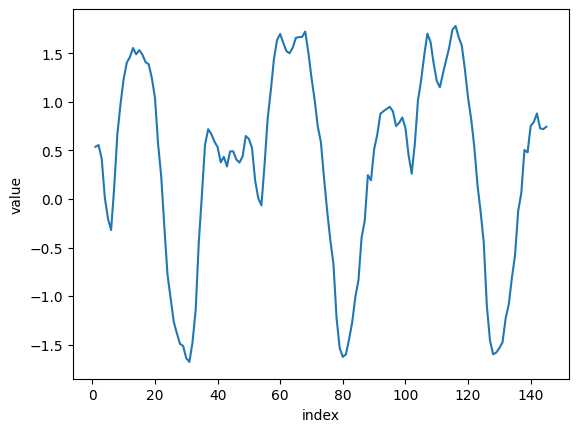

In [13]:
start_step = 0
p = 48  # for one full day
n_windows = 3
sns.lineplot(
    data=df.reset_index().iloc[start_step : 1 + start_step + (p * n_windows)],
    x="index",  # possible since we reset_index to add "index" column
    y="value",
)

Goal is to predict for each new entry (ie, every 30 minutes for the NYC taxi dataset).

Workflow:
- $k$ is the number of sub windows
- Sample one window of $p$ readings 
- Use the encoder to calculate embeddings of this window
- Pass the first 23 embeddings to predict the next 23
- Append the first embedding and make it 24 embeddings
- pass it to Decoder to reconstruct time series.
- Generate score based on MSE
- Generate binary indicator for that time $t$
- Continue to next time step



> From the paper: 
At time $t$, the VAE-LSTM model analyses a test sequence $W_t$ that contains $k \times p$ past readings tracing back from $t$. Our model first uses the encoder from the VAE to estimate the sequence of embeddings $E_t$ in $W_t$. 
Then it feeds the first $k − 1$ embeddings to the LSTM model to predict the next $k − 1$ embeddings. Finally, our model reconstructs the last $k − 1$ windows using the predicted embeddings and the VAE decoder reconstructs the time series.

In [14]:
vae_model = torch.load(VAE_MODEL, map_location=device)
lstm_model = torch.load(LSTM_MODEL, map_location=device)

In [15]:
p = 48  # so that one window is one day

In [16]:
len(data)

12

Loop through the time series to find the anomalies.

In [17]:
df.shape

(4820, 1)

In [18]:
training_stats = {
    "lstm": (0.0658557007260682, 0.9927613388051043),
    "vae": (0.00318042, 0.96157844),
}

In [19]:
# | export


@torch.no_grad()
def predict_next_embeddings(emb, lstm_model):
    lstm_model.eval()
    next_emb = lstm_model(emb)
    return next_emb


@torch.no_grad()
def reconstruct_ts(emb, vae_model):
    vae_model.eval()
    ts = vae_model.decoder(emb)
    return ts

In [114]:
# | export


@torch.no_grad()
def AD(
    past_window,
    vae_model,
    lstm_model,
    window_size=48,
    threshold=0.8,
    latent_dim=24,
    reconstruct_with_true=False,
    stats={"lstm": (0, 1), "vae": (0, 1)},
    normalize=True,
    steps=None,
    # device="cpu",
):
    steps = np.asanyarray(steps)
    if normalize:
        past_window = (past_window - stats["vae"][0]) / stats["vae"][1]
    remainder = len(past_window) % window_size
    if remainder > 0:
        print(
            f"past window not a multiple of window_size! Adjusting for {remainder} extra points."
        )
        past_window = past_window[remainder:]
        steps = steps[remainder:]
    # start
    n_windows = int(len(past_window) / window_size)
    print(f"Number of windows from time series: {n_windows}")
    ad_score = np.zeros(n_windows)
    ad_status = np.zeros((n_windows, window_size))
    ad_window_loc = np.zeros((n_windows, window_size))
    # window = torch.as_tensor(window).to(device=device).unsqueeze(0)
    # print(window.shape)
    emb = get_embeddings(
        past_window, n_windows=n_windows, vae_model=vae_model, latent_dim=latent_dim
    )  # encode 48 steps to 24 embeddings
    n_features = emb.size(-1)
    emb = emb.reshape(1, n_windows, latent_dim, n_features)
    # standardize with training stats
    # print(emb.shape)
    ts = np.zeros((n_windows, window_size))
    past_window = past_window.reshape(ts.shape)
    steps = steps.reshape(ts.shape)
    for widx in range(n_windows):
        emb_idx = emb[:, widx, :, :]
        if normalize:
            emb_idx = (emb_idx - stats["lstm"][0]) / stats["lstm"][1]
        # pass embeddings from 1 to 23, predict 2 to 24
        next_emb = predict_next_embeddings(emb_idx[:, :-1, :], lstm_model=lstm_model)
        # print(next_emb.shape)
        # now can use either the true embeddings for 1-23 and append last prediction of emb
        # or take true embeddings for 1 and prepend to predicted 2-24 emb
        if reconstruct_with_true:
            next_emb = concat_first_emb(
                next_emb[:, -1, :].unsqueeze(0), first_emb=emb_idx[:, :-1, :], dim=1
            )
        else:
            next_emb = concat_first_emb(
                next_emb, first_emb=emb_idx[:, 0, :].unsqueeze(0), dim=1
            )
        next_emb = next_emb[:, :, 0]  # last index not need for decoder
        # VAE decoder
        ts_widx = reconstruct_ts(next_emb, vae_model=vae_model)
        ts_widx = ts_widx.squeeze().detach().numpy()
        ts[widx, :] = ts_widx
        # calculate for this window the anomaly score
        ad_score[widx] = np.linalg.norm(past_window[widx] - ts_widx, 2)
        ad_status[widx, :] = ad_score[widx] > threshold  # global label for all items
        ad_window_loc[widx, :] = steps[widx, :]

    if normalize:
        ts = ts * stats["vae"][1] + stats["vae"][0]
        past_window = past_window * stats["vae"][1] + stats["vae"][0]

    return {
        "reconstructed": ts,
        "actual": past_window,
        "score": ad_score,
        "status": ad_status,
        "steps": steps,
        "threshold": threshold,
    }

In [115]:
df.values.shape

(4820, 1)

In [210]:
threshold = 6
pred = AD(
    df.values,
    vae_model,
    lstm_model,
    window_size=48,
    steps=df.index,
    stats=training_stats,
    threshold=threshold,
    reconstruct_with_true=False,
)
pred

past window not a multiple of window_size! Adjusting for 20 extra points.
Number of windows from time series: 100


{'reconstructed': array([[-0.37095137, -0.71029042, -0.96521639, ...,  1.12072285,
          0.8734631 ,  0.53760717],
        [ 0.14774397, -0.23366639, -0.5530458 , ...,  1.27868252,
          1.12708304,  0.86494387],
        [ 1.17749256,  1.0457286 ,  0.86881661, ...,  1.29616334,
          1.29405921,  1.26996601],
        ...,
        [-0.51005296, -0.85207209, -1.1032039 , ...,  1.03413444,
          0.75924857,  0.39863259],
        [-0.37796968, -0.72115898, -0.97798675, ...,  1.10958686,
          0.86004049,  0.52057116],
        [-0.01572335, -0.39253187, -0.69416234, ...,  1.23456672,
          1.04633556,  0.75154132]]),
 'actual': array([[ 0.56685778,  0.2334616 , -0.28420203, ...,  1.66445086,
          1.6671214 ,  1.72250002],
        [ 1.50548329,  1.24545675,  1.01902284, ...,  1.56184579,
          1.74133438,  1.77998697],
        [ 1.66388864,  1.57786905,  1.3288058 , ..., -0.28265593,
         -0.49137993, -0.69420062],
        ...,
        [-0.68787565, -1.04

# Visualize the anomalies

In [211]:
pred["status"].mean(1)

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1.])

In [212]:
anomaly_windows = pred["steps"] * pred["status"]
anomaly_windows

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       ...,
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [4773., 4774., 4775., ..., 4818., 4819., 4820.]])

In [213]:
true_anomalies = list(data["idx_anomaly_test"])
true_anomalies

[443, 1684, 3027, 3335, 4581]

- [ ] Plot has a shift of 21 due to remainder -> todo

Text(0.5, 1.0, 'Number of previous steps: 4800; L2-threshold: 6')

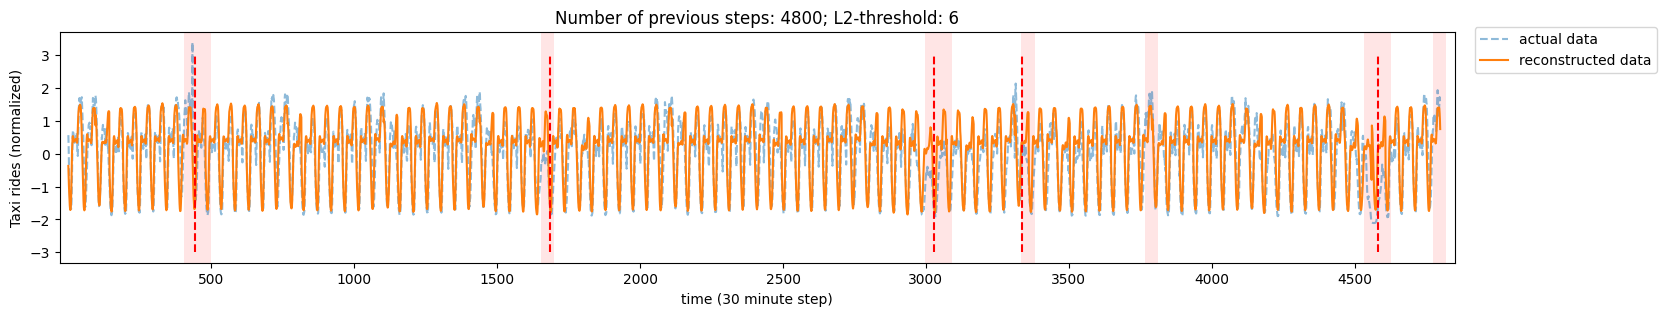

In [215]:
plt.subplots(figsize=(18, 3))
sns.lineplot(pred["actual"].reshape(-1), alpha=0.5, linestyle="--", label="actual data")
sns.lineplot(pred["reconstructed"].reshape(-1), label="reconstructed data")
# sns.lineplot(pred["status"].reshape(-1), label="pred anomaly")
pred_steps_ = pred["steps"].reshape(-1)
for idx, val in enumerate(pred["status"].mean(1)):
    if val == 1:
        plt.axvspan(
            pred["steps"][idx][0],
            pred["steps"][idx][-1],
            facecolor="red",
            alpha=0.1,
        )
for val in true_anomalies:
    plt.vlines(val, -3, 3, linestyles="--", colors="red")
plt.xticks(rotation=45)
plt.xlim(-30, df.shape[0] + 30)
plt.legend(bbox_to_anchor=(1.15, 1.05))
plt.xticks(ticks=[x for x in pred_steps_ if x % 500 == 0], rotation=0)
plt.ylabel("Taxi rides (normalized)")
plt.xlabel("time (30 minute step)")
plt.title(f"Number of previous steps: {len(pred_steps_)}; L2-threshold: {threshold}")

In [216]:
# | hide
import nbdev

nbdev.nbdev_export()